## End of the line

*CCD Colour Synthesis, celestial coordinates, astronomical time, star charts, observability, daylight time*

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os

from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import astropy.units as u

Welcome to the endgame of Physics 164! This notebook is my attempt to include a few vaguely related astronomical techniques that, despite their importance, could not be accommodated by the overall structure of the course. Although some of those techniques may help in completing your last report, most are presented here simply because I deem them important enough to deserve a mention.

I fear that some of you may have spent so much time focusing on specific programming tasks of this course that they forgot that observational astronomy is not just FITS files and transformation matrices. It is my hope that those who choose to follow this notebook will regain the global perspective on astronomy as a window at the infinitely deep night sky and all the wonders that lie beyond.

## Anonymous functions

Before we start, I would like to take a very brief detour into basic Python. By now, you likely noticed that Python functions can be stored and manipulated as variables. For example:

In [3]:
# Define some generic function
def square_root(x):
    """ Computes the square root of x """
    return x ** 0.5

# Now, define a function that accepts another function as an argument
def my_func(another_func, some_argument):
    """ Calls another_func, passing some_argument as an argument """
    return another_func(some_argument)


print my_func(square_root, 4)

# Functions can be stored in variables...
my_variable = square_root
print my_func(my_variable, 4)

# Functions stored in variables can be called...
print my_variable(4)

2.0
2.0
2.0


Functions that are stored in variables, just like in the example above, are often called *anonymous functions*. Since the variables that store these functions can be used to call them, the functions themselves no longer need a permanently-defined name, explaining the meaning of the term.

Python offers a neat shorthand to create very small anonymous functions that are made of a single line of code - the `lambda` statement. The general syntax is:

```python
var = lambda arg1, arg2... : body
```

Here, `var` is variable to save the function in; `arg1`, `arg2` are the arguments of the function and `body` is the body of the function that can rely on the arguments and **must** be made of a single line of code only (technically, a single expression). The function will not need to use the `return` statement, as the output of its only line will be returned automatically.

Here is a simple example:

In [4]:
# First, create a function the usual way
def magnitude(x, y):
    return (x ** 2.0 + y ** 2.0) ** 0.5
print magnitude(1, 1)

# Now do the same with lambda
magnitude = lambda x, y : (x ** 2.0 + y ** 2.0) ** 0.5
print magnitude(1, 1)

# Or, if you only need the function once, it can be even shorter
print (lambda x, y : (x ** 2.0 + y ** 2.0) ** 0.5)(1, 1)

1.41421356237
1.41421356237
1.41421356237


## Colour synthesis

Throughout this course, we dealt with many astronomical images as FITS files, each storing a 2D array of numbers. Originally, those numbers were integers between $0$ and $2^{16}-1=65535$; however, after bias subtraction and flat-fielding they could become fractional and negative. In a regular FITS file, every pixel is represented by a single number, implying that the image is inevitably grayscale.

In this section, we will take three different FITS files taken through three different filters and attempt to combine them together to produce a colour image. Nowadays, the most common way of storing digital colour images is by assigning three numbers to each pixel instead of just one. Typically, these numbers will be integers (because a screen can produce only so many colours) between $0$ and $255$. The three numbers would correspond to the R (red), G (green) and B (blue) channels. The process of this transformation goes by many names: *colour composition*, *trichromy*, *CCD colour synthesis* and more.

<div class="alert alert-info">
    <b>FYI:</b> The idea that every colour can be written out as a sum of three fundamental colours of different intensities is justified by the existence of three different types of cones (colour-sensitive cells) on human retinas. If a screen is able to excite each of the types separately, it should cover the entire range of sensitivity of human vision. Unfortunately, the response of human eyes is more complicated than that and no practical colour system is able to fully mimic it. Therefore, every definition of colour based on three primaries is bound to have a range of shades that cannot be represented. The usual victims are high-value shades that are far from all three primary colours. For example, bright orange hues.
</div>

As an example, we will make a colour image of M51 - [the Whirlpool Galaxy](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=M51&submit=SIMBAD+search) - out of three images provided on GitHub. I took the liberty of choosing three images of M51 (`d1120.fits`, `d1121.fits` and `d1122.fits`) and fully reducing them. To continue, please download and extract that archive. You should find three reduced FITS files named `d1120-R-REDUCED.fits`, `d1121-V-REDUCED.fits` and `d1122-I-REDUCED.fits`. Save them all in the same folder and point Python towards it in the cell below:

In [6]:
data_dir = 'M51/'

Let's load them all in and see what they look like. The `fits` submodule implements a shorthand function named `getdata()` that will open a given FITS file, load the data and close it automatically in a single call. I will also use the `lambda` statement introduced above to reduce the length of the code.

Text(0.5,1,'M51: I-filter')

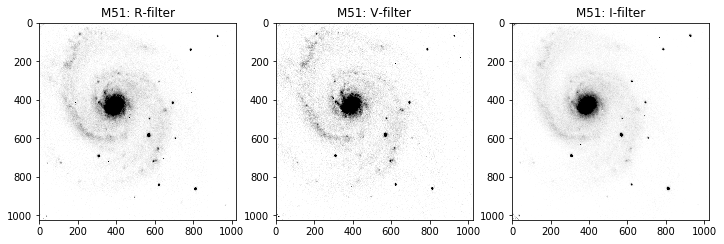

In [7]:
# Load all three frames
R_frame = fits.getdata(data_dir + 'd1120-R-REDUCED.fits')
V_frame = fits.getdata(data_dir + 'd1121-V-REDUCED.fits')
I_frame = fits.getdata(data_dir + 'd1122-I-REDUCED.fits')

# Start a composite plot (1 row, 3 columns) to show all three images side-by-side
figure, axes = plt.subplots(1, 3, figsize = [12, 4])


# Anonymous function to render a plot, choose the palette and set the floor and the ceiling
f = lambda axes, image : axes.imshow(image, cmap = 'Greys', vmin = np.median(image), vmax = np.median(image) * 3.0)

f(axes[0], R_frame); axes[0].set_title('M51: R-filter')
f(axes[1], V_frame); axes[1].set_title('M51: V-filter')
f(axes[2], I_frame); axes[2].set_title('M51: I-filter')

To compose a colour image, we need to make a number of key decisions:

* **What image goes into which channel?** If the aim is to approximate human vision, it would make sense to put the image through the R-filter into the red channel, the image through the V-filter into the green channel and the image through the B-filter into the blue channel, as the transmission profiles of those filters approximate the response curves of human cones the closest. Unfortunately, our dataset does not have any B-filter images, so the final result will necessarily be in false colours. I will send I into the red channel, R into the green channel and B into the blue channel.
* **What are the mixing coefficients of the channels?** We cannot use the images as they are, since the CCD would have very different responses to different wavelengths. For example, we do not want the image to appear excessively red just because the CCD is most sensitive to that colour. We will have to come up with three "mixing coefficients" and multiply the corresponding images by them to compensate for any differences.

For now, I will create a function takes the mixing coefficients as arguments, so that we could adjust those later.

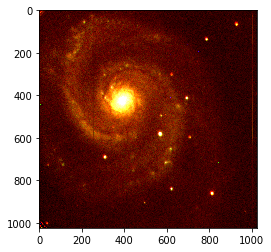

In [8]:
# "r_coef = 1.0" means "set r_coef to 1.0 if no value is provided". Same for other arguments
def trichromy(images, r_coef = 1.0, b_coef = 1.0, g_coef = 1.0, contrast = 3.0):
    """ 
        Produce a colour image out of three greyscale images given a set of mixing coefficients.
        
        images:   List of three 2D images to use for red, green and blue channels respectively.
        r_coef:   The red mixing coefficient (optional, defaults to 1.0)
        b_coef:   The blue mixing coefficient (optional, defaults to 1.0)
        g_coef:   The green mixing coefficient (optional, defaults to 1.0)
        contrast: The multiple of the luminance medium to use as the visualization ceiling (optional, defaults to 3.0)
    """
    
    # Populate the channels and apply the mixing coefficients
    R = images[0] * r_coef
    G = images[1] * b_coef
    B = images[2] * g_coef

    # Compute the luminance (average brightness across all channels) as well. We need it to set
    # the floor and the celing of the visualization
    Lum = (images[0] + images[1] + images[2]) / 3.0

    floor = np.median(Lum)
    ceil = np.median(Lum) * contrast

    # A function to project a float number onto a 0..255 integer scale
    rescale = lambda channel : np.round((channel - floor) / (ceil - floor) * 255).astype(int)
    R = rescale(R)
    G = rescale(G)
    B = rescale(B)

    # To render an RGB image, plt.imshow() expects the channel to be the last dimension
    # np.array([R, G, B]) will have the channel as its first dimension. To fix this,
    # we use np.rollaxis() that swaps the dimensions around
    RGB = np.rollaxis(np.array([R, G, B]), 0, start = 3)
    
    
    plt.imshow(RGB)
    
# Our first test run with mixing coefficients of 1.0 (default)
trichromy([I_frame, R_frame, V_frame])

The image is clearly dominated by the red channel, which needs to be suppressed by adjusting the corresponding mixing coefficient. However, before we address this issue, let's zoom in on a star...

(20, 120)

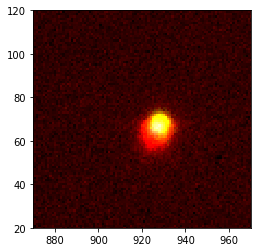

In [9]:
trichromy([I_frame, R_frame, V_frame])
plt.xlim(870, 970)
plt.ylim(20, 120)

Clearly, the red channel suffers from an enlarged FWHM compared to the other two channels and is slightly offset, perhaps due to imperfect tracking by the telescope. While there isn't much we can do about the former issue, we can use the `ndimage` submodule within `scipy` to "shift" the red channel back in place.

(20, 120)

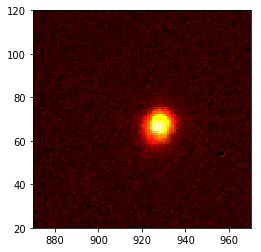

In [10]:
# Import the relevant function from SciPy. shift() can translate images by fractions of a pixel
from scipy.ndimage.interpolation import shift

# The red channel comes from the I-filter frame. Translate the frame...
I_frame_shifted = shift(I_frame, [2.2, 0.7])  # I determined these numbers by trial and error.
                                              # Feel free to change those to see what happens.

trichromy([I_frame_shifted, R_frame, V_frame])
plt.xlim(870, 970)
plt.ylim(20, 120)

<div class="alert alert-info">
    At first, it might seem impossible to translate an image made of discrete pixels by a fraction of the pixel size, as we do above. In practice, this is a very common task in image processing. While carrying out the transformation, we pretend that the resolution of the image is much higher than it actually is. At the end of the transformation, this "enhanced" image is divided into pixels and the signal within each pixel is averaged. This process is known as <i>resampling</i>. Very often, it is able to trick a human eye into believing that the image is much smoother than it actually is.
</div>

The channels are aligned much better now. Next stop: the mixing coefficients. I will use interactive widgets to set those:

In [11]:
# Import ipywidgets to interact with the plot
from ipywidgets import interact, fixed, FloatSlider

# "continuous_update = False" means that the image will refresh only when we let go of the slider
# This is good for performance
widget = lambda description : FloatSlider(min = 0, max = 2, step = 0.1, value = 1.0, description = description, continuous_update = False)
images = fixed([I_frame_shifted, R_frame, V_frame])

interact(trichromy, images = images, r_coef = widget('R'), g_coef = widget('G'), b_coef = widget('B'), contrast = fixed(3));

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTEuMCwgY29udGludW91c191cGRhdGU9RmFsc2UsIGRlc2NyaXB0aW9uPXUnUicsIG1heD0yLjApLCBGbG9hdFNsaWRlcijigKY=


Now the challenge is to find a set of positions for the sliders that gives the best result, where the definition of "best" is, of course, subjective. My personal favourite choice here is $R=0.7$, $B=1.0$ and $G=1.9$. Bellow is a scaled-up image with these mixing coefficients:

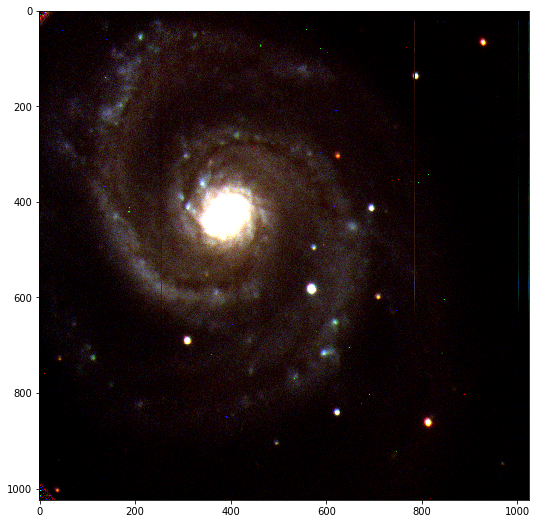

In [12]:
plt.figure(figsize = [9, 9])
trichromy([I_frame_shifted, R_frame, V_frame], r_coef = 0.7, g_coef = 1.9)

<div class="alert alert-info">
    <b>FYI:</b> At this point, some of you may be dissatisfied with our approach, where we change the coefficients as we please until the image "looks good" without any other justification. And you would be right: colour images are very rarely used in quantitative analysis. Instead, they are either used to enhance specific details or to make the image look more appealing (especially in amateur astrophotography).<br><br>
    It is nonetheless possible to approximate human vision through a careful choice of filters and mixing coefficients. The right coefficients could be found by aiming the camera at an object of known colour and adjusting the mixing coefficients until the camera is able to reproduce that colour.<br><br>
    Alternatively, one could choose their mixing coefficients to follow a certain defined standard of false colour representation, such as the <a href="https://www.lightvortexastronomy.com/tutorial-narrowband-hubble-palette.html">Hubble palette</a>.
</div>

## Coordinates and projections

Previously in this course, we queried VizieR for stars in a specific region of the sky. For my current purposes, I need to query the entire sky. Of course, one must be careful to set the limiting magnitude low enough as to prevent the result of the query from being excessively large (the sky is full of stars!).

For now, let us limit ourselves to those stars that can be observed with a pair of binoculars, i.e. the apparent magnitude of $8.0$ or so. The cell below may take a while to run, as this is a large query!

Found 85444 objects


Text(0,0.5,'Dec [deg]')

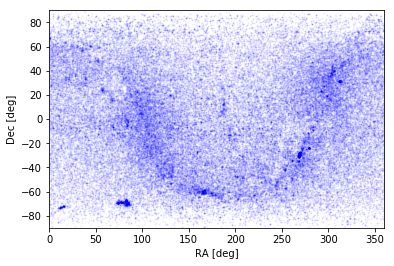

In [13]:
# Create a VizieR object, set the limiting magnitude, relax the results limit and run the query to USNO-B1
my_vizier = Vizier(column_filters = {"R2mag" : "<8.0"})
my_vizier.ROW_LIMIT = -1
result_table = my_vizier.get_catalogs('USNO-B1')

# Extract RAs, Decs and magnitudes
ra  = np.array(result_table[0]["RAJ2000"])
dec = np.array(result_table[0]["DEJ2000"])
mag = np.array(result_table[0]["R2mag"])

print "Found {} objects".format(len(ra))

# Plot everything out. "ms = 2" sets the markers to be two pixels wide. "alpha = 0.05" makes the markers
# semi-transparent. This is a very helpful decoration when plotting a large number of points.
plt.plot(ra, dec, 'b.', ms = 2, alpha = 0.05)
plt.xlim(0, 360)
plt.ylim(-90, 90)
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')

It is hopefully apparent that the distribution of stars is far from random. The stars tend to be clustered along a specific line that looks like a giant "U" in the plot above. This line is the galactic plane, where most of the stars in our galaxy are expected to be found. The bottom left corner reveals two small but distinct darker patches that are the two closest galaxies to ours: the <a href="http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=Small+magellanic+cloud&submit=SIMBAD+search">Small</a> and the <a href="http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=Large+magellanic+cloud&submit=SIMBAD+search">Large Magellanic clouds</a>. Unfortunately, both clouds can never be seen from the norther hemisphere.

A careful eye may spot another interesting feature in the plot. The density of stars falls off drastically at the top and bottom edges of the plot: there are virtually no stars to the north of $\delta=+85°$ and south of $\delta=-85°$. This is an artifact of our attempt to project a sphere onto a rectangular plane. Although no flat projection is perfect, it is possible to get a much better map than the one we have above.

Arguably, the most commonly preferred method for projecting a sphere onto a flat surface is the so-called *Mollweide projection*, proposed by Karl Mollweide back in 1805. The projection preserves equal areas, which makes it convenient for showing distributions of data. Even better, the projection is supported by *MatPlotLib* out of the box.

C:\Users\Roman\AppData\Roaming\Python\Python27\site-packages\matplotlib\projections\geo.py:426: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


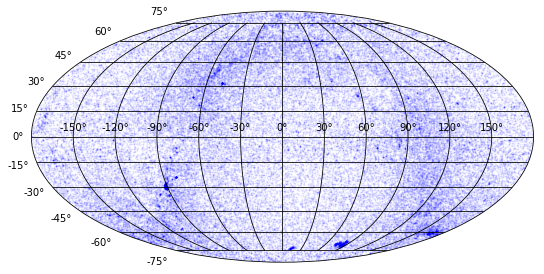

In [14]:
# MatPlotLib projections require angles in radians with the horizontal axis ranging from -pi to +pi
# USNO-B lists angles in the range from 0 to 2pi, so we will have to translate ourselves.
# "%" means "modulo".
ra_rad  = np.radians((ra + 180.0) % 360 - 180)
dec_rad = np.radians(dec)

# Another quirk of MatPlotLib projections is that they must be a part of a combined plot (even if
# no other plots are needed).
figure, axes = plt.subplots(1, 1, subplot_kw = {'projection': 'mollweide'}, figsize = [9, 9])

# scatter() is similar to plot(), but it is optimized for plotting points and allows more control over it.
# "s" sets the size of the point.
axes.scatter(ra_rad, dec_rad, color = 'b', s = 1, alpha = 0.05)

# Add a grid
axes.grid(color = 'k')

*Mollweide* is not the only projection out there. You are encouraged to also try `hammer`, `aitoff` and `lambert`. Each of those fixes some of the distortions by introducing other distoritions.

We will now convert the plot above into *galactic coordinates*. A common misconception is to believe that galactic coordinates somehow describe one's position in the galaxy, which would make them useful to Tony Stark still trying to find his way back home. Unfortunately, the meaning of galactic coordinates is more prosaic than that: they still describe one's position on the sky as observed from Earth, but with the $x$ axis aligned with the galactic plane.

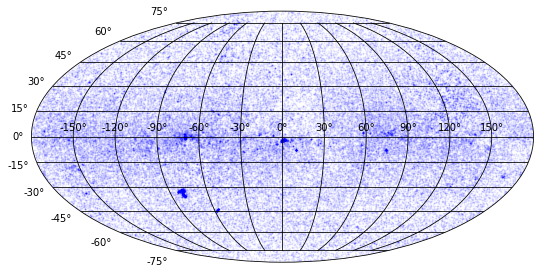

In [15]:
# We will need SkyCoord for any coordinate conversions
from astropy.coordinates import SkyCoord

# First, create a coordinates object, just like in the "Astronomical Catalogues" notebook
coord = SkyCoord(ra = ra_rad, dec = dec_rad, unit = (u.radian, u.radian), frame='icrs')

# We can now extract the galactic latitude (b) and longitude (l) from the coordinates object
# AstroPy can give those back directly in radians and even put them in the right quadrant with wrap_at()
galactic_latitude = coord.galactic.b.radian
galactic_longitude = coord.galactic.l.wrap_at(180 * u.degree).radian

# Plot them out in Mollweide projection
figure, axes = plt.subplots(1, 1, subplot_kw = {'projection': 'mollweide'}, figsize = [9, 9])
axes.scatter(galactic_longitude, galactic_latitude, color = 'b', s = 1, alpha = 0.05)
axes.grid(color = 'k')

It can hopefully be seen that the dense patch of stars is now aligned with the equator of the projection. This is exactly what makes galactic coordinates useful: they represent the natural symmetry of the distribution of stars on the night sky.

## Time and space

RA and Dec and galactic latitude and longitude may be very useful when positioning objects on the celestial sphere. Unfortunately, none of them help us find the object in the sky above us, as both are global coordinate systems, independent of time, date and observer's location. When planning observations, it is often more convenient to specify positions in the *AltAz* coordinate system. In *AltAz*, the coordinates of relevance are the altitude of the object (how high it is above the horizon, in degrees) and its azimuth (angle due North).

Before AstroPy can convert RA and Dec into altitude and azimuth, it needs to know our time and location. Let's start with location:

In [16]:
# We need EarthLocation to create a location object
from astropy.coordinates import EarthLocation

# There are many ways to create a location object. For example...

# By observatory name (for famous observatories)
lick_observatory = EarthLocation.of_site('Lick')
# By latitude and longitude. For La Jolla, lat = 32.8 and long = -117.3 (negative for West)
my_location = EarthLocation.from_geodetic(-117.3, 32.8)


# Once created, the object can be used to read out the properties back
print "The elevation of Lick is {} metres".format(lick_observatory.height)
print "The coordinates of Lick are ({}, {})".format(lick_observatory.lat, lick_observatory.lon)
print "You said that you are at ({}, {})".format(my_location.lat, my_location.lon)

The elevation of Lick is 1290.0 m metres
The coordinates of Lick are (37.3433333333 deg, -121.636666667 deg)
You said that you are at (32.8 deg, -117.3 deg)


Multiple date and time formats are relevant in astronomy. In FITS headers (usually `DATE`), you may find the time of observation saved in the so-called *ISO 8601* format: e.g. `2008-09-15T15:53:00`, where the time is given in UTC, 24h.

To compare dates against one another, it is often useful to express them as a single number. Some of you may be familiar with the *UNIX Timestamp* format, where the date is expressed as the number of seconds since 1st January 1970. For example, the UNIX timestamp of `2008-09-15T15:53:00` is `1221493980`.

In astronomy, we often use *Julian dates* (number of days since January 1, 4713 BC; may be a fraction to represent time), *Modified Julian dates* (same as *Julian dates*, but less by $2400000.5$ days) and Julian epochs (you would have encountered notation like J2000, J2018 etc).

In [17]:
# As before, we will need to import Time to create date objects
from astropy.time import Time

# There are many ways to create a time object. For example...

time_now = Time.now()                     # The time right now
tonight = Time('2019-03-14T07:00:00')     # Through ISO 8601
j2000   = Time(2000, format = 'jyear')    # By epoch

# ... or from FITS
fits_time = Time(fits.getheader(data_dir + 'd1122-I-REDUCED.fits')['DATE'])

# Once created, we can read out different formats
print "The time now is: {} (UTC)".format(time_now.isot)       # Display ISO 8601
print "The Julian date now is: {}".format(time_now.jd)
print "The Modified Julian date now is: {}".format(time_now.mjd)
print "The difference between JD and MJD: {}".format(time_now.jd - time_now.mjd)
print "The UNIX timestamp now is: {}".format(time_now.unix)
print "The current epoch is: J{}".format(time_now.jyear)
print "\nThe FITS image was taken on {}".format(fits_time.isot)

The time now is: 2019-09-11T11:16:33.478 (UTC)
The Julian date now is: 2458737.96983
The Modified Julian date now is: 58737.4698319
The difference between JD and MJD: 2400000.5
The UNIX timestamp now is: 1568200593.48
The current epoch is: J2019.69327812

The FITS image was taken on 2017-03-03T07:15:40.640


With both location and date objects created, we can now convert into *AltAz*. Let's get a chart, showing the brightest stars (visible to a naked eye) later tonight. This time, I will use a polar projection.

(0, 90)

<Figure size 504x504 with 0 Axes>

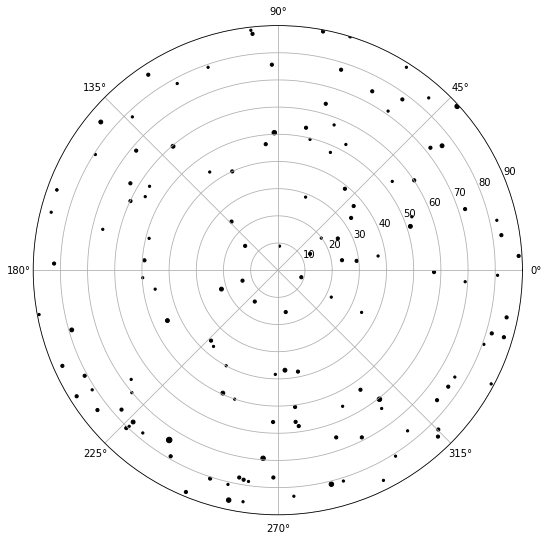

In [18]:
# Need AltAz to calculate transformations
from astropy.coordinates import AltAz

# Create a frame of reference, based on desired date/time and location
frame = AltAz(obstime = tonight, location = my_location)

# Transform into AltAz
transformed_coord = coord.transform_to(frame)

# Read out
alt = 90 - transformed_coord.alt.deg   # Altitudes are measured from the horizon. To place the objects in zenith
                                       # at the centre of the plot, we need the altitude to be measured from zenith.
                                       # Hence, the subtraction
az = transformed_coord.az.rad

# Only show the brightest stars
condition = (mag < 3.0)


# Plot brighter stars with larger markers
plt.figure(figsize = [7, 7])
figure, axes = plt.subplots(1, 1, subplot_kw = {'projection': 'polar'}, figsize = [9, 9])
axes.scatter(az[condition], alt[condition], color = 'k', s = np.round(4 - mag[condition]) * 5)
axes.set_ylim(0, 90)

I challenge you to find *Ursa Major*, *Orion*, perhaps other famous constellations and, of course, *Polaris*.

## Observability charts

Now let's focus on a very specific star and figure out when it is observable from La Jolla. I will go for Betelgeuse - the time bomb of the galaxy (can you find it in the chart above?). We can use *AltAz* to work out when the star is above the horizon:

Text(0,0.5,'Altitude [deg]')

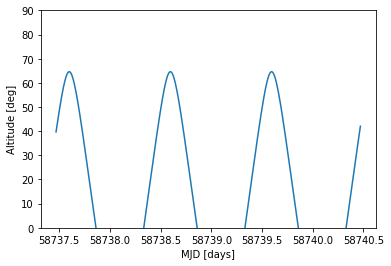

In [19]:
# Let's get a prediction for the next 3 days...
start = Time.now().jd
end = start + 3

# Create a date object, storing 1000 dates between now and three days from now
time_grid = Time(np.linspace(start, end, 1000), format = 'jd')

# Simbad will tell us the RA and Dec of Betelgeuse
result_table = Simbad.query_object('Betelgeuse')
ra_star = result_table[0]["RA"]
dec_star = result_table[0]["DEC"]

# We can use those to create a coordinates object...
coord_star = SkyCoord(ra_star, dec_star, unit=(u.hour, u.deg), frame='icrs')

# And a frame of reference:
frame = AltAz(obstime = time_grid, location = my_location)

# From which we can get the altitude of Betelgeuse at every single one of the 1000 requested times
alt_star = coord_star.transform_to(frame).altaz.alt.deg

# Plot altitude VS modified Julian date
plt.plot(time_grid.mjd, alt_star)
plt.ylim(0, 90)
plt.xlabel('MJD [days]')
plt.ylabel('Altitude [deg]')

The plot above shows when Betelgeuse rises and sets; however, it is not enough for an object to be above the horizon to be visible. Another important condition is that it must be dark, i.e. the sun must be deep enough below the horizon. Unlike other stars, the sun changes its celestial coordinates throughout the year. Fortunately, *AstroPy* comes with a built-in routine for predicting them at any given time:

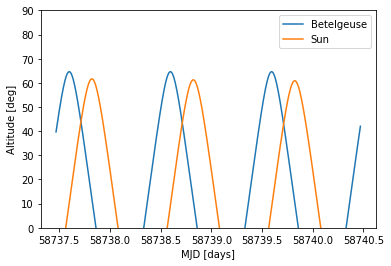

In [20]:
from astropy.coordinates import get_sun

coord_sun = get_sun(time_grid)   # get_sun gives us the coordinates object of the sun for all requested times
alt_sun = coord_sun.transform_to(frame).altaz.alt.deg

plt.plot(time_grid.mjd, alt_star, label = "Betelgeuse")
plt.plot(time_grid.mjd, alt_sun, label = "Sun")
plt.ylim(0, 90)
plt.xlabel('MJD [days]')
plt.ylabel('Altitude [deg]')
plt.legend()

Now we can see when the sun rises and sets alongside Betelgeuse. It may also be useful to know the specific time when the Sun rises and sets as well as the times when it sinks 6 degrees below the horizon (civil twilight), 12 degrees (nautical twilight) and 18 degrees (astronomical twilight). To accomplish this, we will have to take the solar altitude as a function of time, equate it to the elevation we want (0, 6, 12 or 18 degrees) and solve it.

It would not be hard to write an equation solver from first principles; however, I would like to use this opportunity to demonstrate the one built-in *SciPy*:

In [21]:
# UnivariateSpline can smoothly interpolate data series into continuous functions. It can also solve equations
from scipy.interpolate import UnivariateSpline

# I want to represent the times in the local timezone. AstroPy only works in UTC, so we load the built-in Python
# module for date handling...
from datetime import datetime

# Find all times when the sun is at some altitude...
get_roots = lambda alt : UnivariateSpline(time_grid.mjd, alt_sun - alt, s = 0).roots()

def print_suntimes(alt):
    """ Print out all times (in local TZ) when the Sun hits a specific altitude """
    for root in get_roots(alt):
        # Use AstroPy to get the UNIX timestamp of the date
        unix_timestamp = Time(root, format = "mjd").unix
        # Use that timestamp and the datetime module to get the time in the local TZ
        local_time = datetime.fromtimestamp(unix_timestamp)
        print local_time

print "Upcoming sunrises / sunsets"
print_suntimes(0)
print "\nCivil twilight starts / ends"
print_suntimes(6)
print "\nNautical twilight starts / ends"
print_suntimes(12)

Upcoming sunrises / sunsets
2019-09-11 06:34:11.231002
2019-09-11 18:56:54.832482
2019-09-12 06:34:49.293881
2019-09-12 18:55:34.254705
2019-09-13 06:35:27.374141
2019-09-13 18:54:13.476137

Civil twilight starts / ends
2019-09-11 07:02:48.562966
2019-09-11 18:28:20.237412
2019-09-12 07:03:25.859121
2019-09-12 18:27:00.378507
2019-09-13 07:04:03.279249
2019-09-13 18:25:40.211901

Nautical twilight starts / ends
2019-09-11 07:31:22.795143
2019-09-11 17:59:48.274618
2019-09-12 07:32:00.248730
2019-09-12 17:58:28.219410
2019-09-13 07:32:37.937450
2019-09-13 17:57:07.744996
